# Videte Wheel
## Install Requirements

In [1]:
!conda install -y control slycot tqdm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - control
    - slycot
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    control-0.8.3              |           py38_1         351 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    slycot-0.4.0.0             |   py38h8872ae6_1         676 KB  conda-forge
    tqdm-4.48.2                |     pyh9f0ad1d_0          53 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  control            conda-forge/linux-64::contro

## Videte Wheel Kinematics
### Basic Definitions

In [167]:
import sympy

# Declare Time
t = sympy.symbols('t')

# Declare Functions
y = sympy.Function('y')(t)
θ = sympy.Function('θ')(t)
ρ = sympy.Function('ρ')(t)
φ = sympy.Function('φ')(t)

# Declare Masses
m_ow, m_ow_rot, m_iw, m_iw_rot, m_m = sympy.symbols('m_ow m_owr m_iw m_iwr m_m')

# Declare Dimensions
l_iw_m, r_1, r_2, r_3, r_m = sympy.symbols('l_iwm r_1 r_2 r_3 r_m')
l_ow_iw = r_2 - r_1

# Declare Gravity
g = sympy.symbols('g')

In [168]:
# Gear ratio
i_gear = r_2 / r_1

# Linking rotation of outer and inner wheel
φ_iw = φ
φ_ow = (1/i_gear) * φ_iw # virtual rotation of outer wheel (outer wheel movement depends on ρ)

ω = φ.diff(t)
ω_iw = ω
ω_ow = φ_ow.diff(t)

ω_ow

r_1*Derivative(φ(t), t)/r_2

In [169]:
# Y positions
y_ow = r_3 + y
y_iw = y_ow - l_ow_iw * sympy.cos(ρ)
y_m = y_iw + l_iw_m * sympy.cos(θ)

# Rotation based x movement
# TODO: Check to be correct
x = r_3 * (φ_ow - ρ)

# X positions
x_ow = x
x_iw = x_ow + l_ow_iw * sympy.sin(ρ)
x_m = x_iw + l_iw_m * sympy.sin(θ)

### State X

In [170]:
state_x = [θ, θ.diff(t), ρ, ρ.diff(t), φ, φ.diff(t)]

state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

### Potential Energy

In [171]:
V = (m_m * y_m + m_ow * y_ow + m_iw * y_iw) * g

V

g*(m_iw*(r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_m*(l_iwm*cos(θ(t)) + r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_ow*(r_3 + y(t)))

### Kinetic Energy

In [172]:
# Rotating mass inertia
J_ow_rot = (1/2) * m_ow_rot * (r_2**2 + r_3**2)
J_iw_rot = (1/2) * m_iw_rot * r_1**2

# Steinerscher Satz (Gieck M2 & M3)
J_ow = m_ow * l_ow_iw**2 + m_ow * r_2**2
J_m = m_m * l_iw_m**2 + (m_m / 2) * r_m**2

J_iw = J_ow_rot + J_iw_rot

# Kinetic energy of rotating cylinder
W_owr = (1/2) * J_ow_rot * ω_ow**2
W_iwr = (1/2) * J_iw_rot * ω_iw**2

# Translational kinetic energy
W_ow = (1/2) * m_ow * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2)
W_iw = (1/2) * m_iw * (sympy.diff(x_iw, t)**2 + sympy.diff(y_iw, t)**2)
W_m = (1/2) * m_m * (sympy.diff(x_m, t)**2 + sympy.diff(y_m, t)**2)

# Dampening (e.g. heat dissipation)
d_ow, d_iw, d_m, d_owr, d_iwr = sympy.symbols(
    'd_ow d_iw d_m d_owr d_iwr')

W_d_ow = sympy.integrate(
    d_ow * (1/2) * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2), t)
W_d_iw = sympy.integrate(d_iw * (1/2) * sympy.diff(ρ, t)**2, t)
W_d_m = sympy.integrate((d_m * (1/2) * sympy.diff(θ, t)**2), t)
W_d_owr = sympy.integrate(d_owr * (1/2) * ω_ow**2, t)
W_d_iwr = sympy.integrate(d_iwr * (1/2) * ω_iw**2, t)

W_heat = W_d_iw + W_d_m + W_d_ow + W_d_owr + W_d_iwr

# Holding Force Outer Wheel
F_hx_ow = sympy.symbols(
    'F_hx_ow')

W_r_x = sympy.integrate(F_hx_ow * (1/2) * sympy.diff(x_ow, t)**2, t)

# Kinetic Energy
T = W_ow + W_iw + W_m + W_owr + W_iwr + W_heat + W_r_x

T.simplify()

(0.5*F_hx_ow*r_3**2*(r_1**2*Integral(Derivative(φ(t), t)**2, t) - 2*r_1*r_2*Integral(Derivative(ρ(t), t)*Derivative(φ(t), t), t) + r_2**2*Integral(Derivative(ρ(t), t)**2, t)) + 0.5*d_ow*(r_1**2*r_3**2*Integral(Derivative(φ(t), t)**2, t) - 2*r_1*r_2*r_3**2*Integral(Derivative(ρ(t), t)*Derivative(φ(t), t), t) + r_2**2*r_3**2*Integral(Derivative(ρ(t), t)**2, t) + r_2**2*Integral(Derivative(y(t), t)**2, t)) + 0.5*d_owr*r_1**2*Integral(Derivative(φ(t), t)**2, t) + 0.5*m_iw*(r_2**2*((r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) - Derivative(y(t), t))**2 + (-r_2*(r_1 - r_2)*cos(ρ(t))*Derivative(ρ(t), t) + r_3*(r_1*Derivative(φ(t), t) - r_2*Derivative(ρ(t), t)))**2) + 0.5*m_m*(r_2**2*(l_iwm*sin(θ(t))*Derivative(θ(t), t) + (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) - Derivative(y(t), t))**2 + (r_2*(l_iwm*cos(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*cos(ρ(t))*Derivative(ρ(t), t)) + r_3*(r_1*Derivative(φ(t), t) - r_2*Derivative(ρ(t), t)))**2) + 0.5*m_ow*(r_2**2*Derivative(y(t), t)**2 + r_3**2*(r_1*Deri

### Lagrange Equation

In [8]:
L = T - V

L.simplify()

(0.5*F_hx_ow*r_3**2*(r_1**2*Integral(Derivative(φ(t), t)**2, t) - 2*r_1*r_2*Integral(Derivative(ρ(t), t)*Derivative(φ(t), t), t) + r_2**2*Integral(Derivative(ρ(t), t)**2, t)) + 0.5*d_ow*(r_1**2*r_3**2*Integral(Derivative(φ(t), t)**2, t) - 2*r_1*r_2*r_3**2*Integral(Derivative(ρ(t), t)*Derivative(φ(t), t), t) + r_2**2*r_3**2*Integral(Derivative(ρ(t), t)**2, t) + r_2**2*Integral(Derivative(y(t), t)**2, t)) + 0.5*d_owr*r_1**2*Integral(Derivative(φ(t), t)**2, t) + 0.5*m_iw*(r_2**2*((r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) - Derivative(y(t), t))**2 + (-r_2*(r_1 - r_2)*cos(ρ(t))*Derivative(ρ(t), t) + r_3*(r_1*Derivative(φ(t), t) - r_2*Derivative(ρ(t), t)))**2) + 0.5*m_m*(r_2**2*(l_iwm*sin(θ(t))*Derivative(θ(t), t) + (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) - Derivative(y(t), t))**2 + (r_2*(l_iwm*cos(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*cos(ρ(t))*Derivative(ρ(t), t)) + r_3*(r_1*Derivative(φ(t), t) - r_2*Derivative(ρ(t), t)))**2) + 0.5*m_ow*(r_2**2*Derivative(y(t), t)**2 + r_3**2*(r_1*Deri

In [9]:
f_θ = θ.diff(t)
L_θ = sympy.diff(sympy.diff(L, sympy.diff(θ, t)), t) - sympy.diff(L, θ)
f_dθ = sympy.solve(L_θ, θ.diff(t, t))[0].simplify()

f_ρ = ρ.diff(t)
L_ρ = sympy.diff(sympy.diff(L, sympy.diff(ρ, t)), t) - sympy.diff(L, ρ)
f_dρ = sympy.solve(L_ρ, ρ.diff(t, t))[0].simplify()

f_φ = φ.diff(t)
L_φ = sympy.diff(sympy.diff(L, sympy.diff(φ, t)), t) - sympy.diff(L, φ)
f_dφ = sympy.solve(L_φ, φ.diff(t, t))[0].simplify()

In [10]:
f_dθ

(-d_m*r_2*Derivative(θ(t), t) - l_iwm*m_m*r_1*r_3*cos(θ(t))*Derivative(φ(t), (t, 2)) + l_iwm*m_m*r_2*(g*sin(θ(t)) - r_1*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2 + r_1*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2)) + r_2*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2 - r_2*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2)) + r_3*cos(θ(t))*Derivative(ρ(t), (t, 2)) + sin(θ(t))*Derivative(y(t), (t, 2))))/(l_iwm**2*m_m*r_2)

In [11]:
f_dρ

(F_hx_ow*r_1*r_3**2*Derivative(φ(t), t) - F_hx_ow*r_2*r_3**2*Derivative(ρ(t), t) - d_iw*r_2*Derivative(ρ(t), t) + d_ow*r_1*r_3**2*Derivative(φ(t), t) - d_ow*r_2*r_3**2*Derivative(ρ(t), t) + g*m_iw*r_1*r_2*sin(ρ(t)) - g*m_iw*r_2**2*sin(ρ(t)) + g*m_m*r_1*r_2*sin(ρ(t)) - g*m_m*r_2**2*sin(ρ(t)) - l_iwm*m_m*r_1*r_2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_1*r_2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) + l_iwm*m_m*r_2**2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*r_2**2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) - l_iwm*m_m*r_2*r_3*sin(θ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_2*r_3*cos(θ(t))*Derivative(θ(t), (t, 2)) + m_iw*r_1**2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_1*r_2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_iw*r_1*r_3**2*Derivative(φ(t), (t, 2)) - m_iw*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_2**2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_m*

In [12]:
f_dφ

2.0*(-F_hx_ow*r_1**2*r_3**2*Derivative(φ(t), t) + F_hx_ow*r_1*r_2*r_3**2*Derivative(ρ(t), t) - d_iwr*r_2**2*Derivative(φ(t), t) - d_ow*r_1**2*r_3**2*Derivative(φ(t), t) + d_ow*r_1*r_2*r_3**2*Derivative(ρ(t), t) - d_owr*r_1**2*Derivative(φ(t), t) + l_iwm*m_m*r_1*r_2*r_3*sin(θ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*r_1*r_2*r_3*cos(θ(t))*Derivative(θ(t), (t, 2)) - m_iw*r_1**2*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_iw*r_1**2*r_2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_1*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_1*r_2**2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)) - m_m*r_1**2*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_m*r_1**2*r_2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_1*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_m*r_1*r_2**2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)) + m_ow*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)))/(r_1**2*(2.0*m_iw*r_3**2 + m_iwr*r_2**2 + 2.0*m_m*r_3

In [13]:
state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

In [14]:
eqs = [f_θ, f_dθ, f_ρ, f_dρ, f_φ, f_dφ]

### Create A Matrix

In [15]:
def createMatrix(eqs: list, states: list) -> sympy.Matrix:
    if (len(eqs) != len(states)):
        print("eqs and states must have the same size")
    A = sympy.zeros(len(eqs), len(eqs))
    for i, eq in enumerate(eqs, start=0):
        for j, state in enumerate(states, start=0):
            A[i, j] = sympy.diff(eq, state)
    return A

In [16]:
A = createMatrix(eqs, state_x)

A

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                                                                                                                                                                                                                   

In [17]:
import math

def linearice(A, x, ddx):
    linearice_values = [
        (sympy.sin(θ), math.sin(x['θ'])),
        (sympy.cos(θ), math.cos(x['θ'])),
        (sympy.sin(ρ), math.sin(x['ρ'])),
        (sympy.cos(ρ), math.cos(x['ρ'])),
        (θ.diff(t, t), ddx[0]),
        (θ.diff(t), x['θ_dot']),
        (θ, x['θ']),
        (ρ.diff(t, t), ddx[1]),
        (ρ.diff(t), x['ρ_dot']),
        (ρ, x['ρ']),
        (φ.diff(t, t), ddx[2]),
        (φ.diff(t), x['φ_dot']),
        (φ, x['φ']),
        # Can't move y position (Could .. but should not ..) 
        (y.diff(t, t), 0),
        (y.diff(t), 0),
        (y, 0)
    ]
    return A.subs(linearice_values)

In [18]:
A_lin_up = linearice(A, {'θ': 0, 'θ_dot': 0, 'ρ': 0, 'ρ_dot': 0, 'φ': 0, 'φ_dot': 0}, [0, 0, 0])
A_lin_down = linearice(A, {'θ': math.pi, 'θ_dot': 0, 'ρ': 0, 'ρ_dot': 0, 'φ': 0, 'φ_dot': 0}, [0, 0, 0])

In [19]:
import numpy as np

theta_x_scale = []
theta_dot_x_scale = []
blocked_x_scale = []

for theta in np.arange(-math.pi, math.pi, 2 * math.pi / 60):
    theta_x_scale.append(theta)
    
for theta_dot in np.arange(-4 * math.pi, 4 * math.pi, 8 * math.pi / 10):
    theta_dot_x_scale.append(theta_dot)
    
for blockage in np.arange(0, 200, 200 / 10):
    blocked_x_scale.append(blockage)

In [20]:
import pandas as pd

params = pd.DataFrame([{'θ': 0.1, 'θ_dot': 0, 'ρ': 0, 'ρ_dot': 0, 'φ': 0, 'φ_dot': 0,'test': "r"}, {'type': "initial", 'θ': 0, 'θ_dot': 0, 'ρ': 0, 'ρ_dot': 0, 'φ': 0, 'φ_dot': 0}])
amatrixs = pd.DataFrame([{'A': A}])

pd.concat([params,amatrixs], axis=1)

,θ,θ_dot,ρ,ρ_dot,φ,φ_dot,test,type,A
0,0.1,0,0,0,0,0,r,NaN,"[0, 1, 0, 0, 0, 0, (l_iwm*m_m*r_1*r_3*sin(θ(t)..."
1,0.0,0,0,0,0,0,NaN,initial,NaN


In [21]:
def get_rand_params_df(name, size):
    rand_angle = np.random.uniform(-math.pi, math.pi, [size, 3])
    rand_angle_dot = np.random.normal(0, 4 * math.pi, [size, 3])

    df_rand_angle = pd.DataFrame(rand_angle, columns=['θ', 'ρ', 'φ'])
    df_rand_angle_dot = pd.DataFrame(rand_angle_dot, columns=['θ_dot', 'ρ_dot', 'φ_dot'])
    df_rand = pd.concat([df_rand_angle,df_rand_angle_dot], axis=1)
    df_rand['type'] = name
    return df_rand

linearization_params = get_rand_params_df("test_function", 3)

linearization_params

,θ,ρ,φ,θ_dot,ρ_dot,φ_dot,type
0,2.638197,-0.398869,2.853857,-6.295850,-0.239495,0.738042,test_function
1,1.267084,-0.284887,2.654544,-4.570403,7.407254,-8.486045,test_function
2,-1.764865,-1.229476,2.628258,-13.737627,-3.728041,-18.941388,test_function


In [98]:
angle_cols = ['θ', 'θ_dot', 'ρ', 'ρ_dot', 'φ', 'φ_dot']

In [22]:
from tqdm import tqdm

linearization_params = pd.DataFrame([{'type': "initial", 'θ': 0, 'θ_dot': 0, 'ρ': 0, 'ρ_dot': 0, 'φ': 0, 'φ_dot': 0}])

for angle in tqdm(theta_x_scale):
    for angle_dot in theta_dot_x_scale:
        linearization_params = linearization_params.append([{'type': "θ θ_dot", 'θ': angle, 'θ_dot': angle_dot, 'ρ': 0, 'ρ_dot': 0, 'φ': 0, 'φ_dot': 0}], ignore_index=True)
        linearization_params = linearization_params.append([{'type': "ρ ρ_dot", 'θ': 0, 'θ_dot': 0, 'ρ': angle, 'ρ_dot': angle_dot, 'φ': 0, 'φ_dot': 0}], ignore_index=True)
        linearization_params = linearization_params.append([{'type': "φ φ_dot", 'θ': 0, 'θ_dot': 0, 'ρ': 0, 'ρ_dot': 0, 'φ': angle, 'φ_dot': angle_dot}], ignore_index=True)
        linearization_params = linearization_params.append([{'type': "diagonal", 'θ': angle, 'θ_dot': angle_dot, 'ρ': angle, 'ρ_dot': angle_dot, 'φ': angle, 'φ_dot': angle_dot}], ignore_index=True)
        linearization_params = linearization_params.append([{'type': "crossdiagonal", 'θ': angle * -1, 'θ_dot': angle_dot * -1, 'ρ': angle, 'ρ_dot': angle_dot, 'φ': angle, 'φ_dot': angle_dot * -1}], ignore_index=True)

linearization_params = linearization_params.append(get_rand_params_df("random", 3000), ignore_index=True)
linearization_params = linearization_params.append(get_rand_params_df("random_test", 3000), ignore_index=True)

linearization_params

100%|██████████| 60/60 [00:06<00:00,  8.85it/s]


,type,θ,θ_dot,ρ,ρ_dot,φ,φ_dot
0,initial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,θ θ_dot,-3.141593,-12.566371,0.000000,0.000000,0.000000,0.000000
2,ρ ρ_dot,0.000000,0.000000,-3.141593,-12.566371,0.000000,0.000000
3,φ φ_dot,0.000000,0.000000,0.000000,0.000000,-3.141593,-12.566371
4,diagonal,-3.141593,-12.566371,-3.141593,-12.566371,-3.141593,-12.566371
...,...,...,...,...,...,...,...
8996,random_test,1.814601,-11.885614,-2.539401,-14.942517,-1.112417,-10.591907
8997,random_test,-2.740134,1.906087,-0.382722,5.977617,0.766728,32.918423
8998,random_test,-0.558383,21.929451,-1.099838,10.272705,0.852753,10.522222
8999,random_test,-0.924295,-11.767550,-1.682154,8.527161,-2.866051,3.841383


### Linerace A Matrix according to Dateframe

Be carefull this takes quite long

In [241]:
def linearice_df(x):
    return linearice(A, x, [0, 0, 0])

In [242]:
tqdm.pandas()
a_matrixs = linearization_params.progress_apply(linearice_df, axis=1)

params_a_matrixs = pd.concat([linearization_params,a_matrixs], axis=1)
params_a_matrixs.rename(columns={0:'A_lin'}, inplace=True)

params_a_matrixs

100%|██████████| 9001/9001 [2:20:15<00:00,  1.07it/s]  


,type,θ,θ_dot,ρ,ρ_dot,φ,φ_dot,A_lin
0,initial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2..."
1,θ θ_dot,-3.141593,-12.566371,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, -1.0*g/l_iwm, -d_m/(l_iwm**..."
2,ρ ρ_dot,0.000000,0.000000,-3.141593,-12.566371,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, (1.0*g + 157.91367041743*r_..."
3,φ φ_dot,0.000000,0.000000,0.000000,0.000000,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2..."
4,diagonal,-3.141593,-12.566371,-3.141593,-12.566371,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, (-1.0*g - 157.91367041743*r..."
...,...,...,...,...,...,...,...,...
8996,random_test,1.444730,24.167257,-1.005188,1.260403,1.870214,1.292883,"[0, 1, 0, 0, 0, 0, (0.125732502254821*g - 1.43..."
8997,random_test,-2.275765,-2.122173,3.136602,-1.638845,0.831188,3.337791,"[0, 1, 0, 0, 0, 0, (-0.648010084406281*g - 1.7..."
8998,random_test,1.425980,8.966868,0.892082,17.479375,0.951970,-6.370813,"[0, 1, 0, 0, 0, 0, (0.144311135814616*g + 207...."
8999,random_test,0.689943,-4.999794,2.297418,11.747364,-2.077614,10.602222,"[0, 1, 0, 0, 0, 0, (0.771282541307871*g + 136...."


In [246]:
import pickle

pkl_filename = "a_matrixs.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(params_a_matrixs, file)
    
pd.read_pickle(pkl_filename)

,type,θ,θ_dot,ρ,ρ_dot,φ,φ_dot,A_lin
0,initial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2..."
1,θ θ_dot,-3.141593,-12.566371,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, -1.0*g/l_iwm, -d_m/(l_iwm**..."
2,ρ ρ_dot,0.000000,0.000000,-3.141593,-12.566371,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, (1.0*g + 157.91367041743*r_..."
3,φ φ_dot,0.000000,0.000000,0.000000,0.000000,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2..."
4,diagonal,-3.141593,-12.566371,-3.141593,-12.566371,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, (-1.0*g - 157.91367041743*r..."
...,...,...,...,...,...,...,...,...
8996,random_test,1.444730,24.167257,-1.005188,1.260403,1.870214,1.292883,"[0, 1, 0, 0, 0, 0, (0.125732502254821*g - 1.43..."
8997,random_test,-2.275765,-2.122173,3.136602,-1.638845,0.831188,3.337791,"[0, 1, 0, 0, 0, 0, (-0.648010084406281*g - 1.7..."
8998,random_test,1.425980,8.966868,0.892082,17.479375,0.951970,-6.370813,"[0, 1, 0, 0, 0, 0, (0.144311135814616*g + 207...."
8999,random_test,0.689943,-4.999794,2.297418,11.747364,-2.077614,10.602222,"[0, 1, 0, 0, 0, 0, (0.771282541307871*g + 136...."


In [23]:
A_lin_up

Matrix([
[          0,                   1,                                                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                                                                                                      0, 0,                                                                                                                                                                                                                                                          0],
[1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                             

In [24]:
A_lin_down

Matrix([
[           0,                   1,                                                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                                                                                                      0, 0,                                                                                                                                                                                                                                                          0],
[-1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                           

### Robot Specifications

In [25]:
constants = {
    g: 9.81
}

masses = {
    m_ow: 0.4,
    m_ow_rot: 0.2,
    m_iw: 0.7,
    m_iw_rot: 0.1,
    m_m: 1.0
}

lengths = {
    l_iw_m: 0.082,
    r_1: 0.073 / 2,
    r_2: 0.183 / 2,
    r_3: 0.205 / 2,
    r_m: 0.076 / 2
}

dampening = {
    d_ow: .01,
    d_iw: .01,
    d_m: .01,
    d_owr: .01,
    d_iwr: .01
}

blocked = {
    F_hx_ow: 200
}

free = {
    F_hx_ow: 0
}

specs = {**constants, **masses, **lengths, **dampening}

specs

{g: 9.81,
 m_ow: 0.4,
 m_owr: 0.2,
 m_iw: 0.7,
 m_iwr: 0.1,
 m_m: 1.0,
 l_iwm: 0.082,
 r_1: 0.0365,
 r_2: 0.0915,
 r_3: 0.1025,
 r_m: 0.038,
 d_ow: 0.01,
 d_iw: 0.01,
 d_m: 0.01,
 d_owr: 0.01,
 d_iwr: 0.01}

### Create Jacobian

In [26]:
import numpy as np

A_j_up = np.float64(sympy.simplify(A_lin_up.subs(specs).subs(free)))
A_j_up_blocked = np.float64(sympy.simplify(A_lin_up.subs(specs).subs(blocked)))
A_j_down = np.float64(sympy.simplify(A_lin_down.subs(specs).subs(free)))

In [27]:
sympy.Matrix(A_j_up)

Matrix([
[             0.0,               1.0,               0.0,                0.0, 0.0,                 0.0],
[119.634146341463, -1.48720999405116,               0.0,                0.0, 0.0,                 0.0],
[             0.0,               0.0,               0.0,                1.0, 0.0,                 0.0],
[             0.0,               0.0, -114.110566829951,  -1.25714174636498, 0.0, 0.00521392459007896],
[             0.0,               0.0,               0.0,                0.0, 0.0,                 1.0],
[             0.0,               0.0,               0.0, 0.0108075631630771, 0.0,   -2.99340304322319]])

In [28]:
sympy.Matrix(A_j_up_blocked)

Matrix([
[             0.0,               1.0,               0.0,               0.0, 0.0,               0.0],
[119.634146341463, -1.48720999405116,               0.0,               0.0, 0.0,               0.0],
[             0.0,               0.0,               0.0,               1.0, 0.0,               0.0],
[             0.0,               0.0, -114.110566829951, -262.667607495529, 0.0,  104.283705726169],
[             0.0,               0.0,               0.0,               0.0, 0.0,               1.0],
[             0.0,               0.0,               0.0,  216.162070824705, 0.0, -89.2176774590294]])

In [29]:
sympy.Matrix(A_j_up_blocked - A_j_up)

Matrix([
[0.0, 0.0, 0.0,               0.0, 0.0,               0.0],
[0.0, 0.0, 0.0,               0.0, 0.0,               0.0],
[0.0, 0.0, 0.0,               0.0, 0.0,               0.0],
[0.0, 0.0, 0.0, -261.410465749164, 0.0,  104.278491801579],
[0.0, 0.0, 0.0,               0.0, 0.0,               0.0],
[0.0, 0.0, 0.0,  216.151263261542, 0.0, -86.2242744158062]])

In [30]:
A_j_up

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.19634146e+02, -1.48720999e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.14110567e+02,
        -1.25714175e+00,  0.00000000e+00,  5.21392459e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.08075632e-02,  0.00000000e+00, -2.99340304e+00]])

In [31]:
sympy.Matrix(A_j_down)

Matrix([
[              0.0,               1.0,               0.0,                0.0, 0.0,                 0.0],
[-119.634146341463, -1.48720999405116,               0.0,                0.0, 0.0,                 0.0],
[              0.0,               0.0,               0.0,                1.0, 0.0,                 0.0],
[              0.0,               0.0, -114.110566829951,  -1.25714174636498, 0.0, 0.00521392459007896],
[              0.0,               0.0,               0.0,                0.0, 0.0,                 1.0],
[              0.0,               0.0,               0.0, 0.0108075631630771, 0.0,   -2.99340304322319]])

### Create Jacobian for Dataframe

In [258]:
def apply_specs(row):
    return row['A_lin'].subs(specs)

In [259]:
A_j_matrixs = params_a_matrixs.progress_apply(apply_specs, axis=1)
params_a_matrixs = params_a_matrixs.assign(A_j_F = A_j_matrixs)

params_a_matrixs

100%|██████████| 9001/9001 [1:11:58<00:00,  2.08it/s]


,type,θ,θ_dot,ρ,ρ_dot,φ,φ_dot,A_lin,A_j_F
0,initial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2...","[0, 1, 0, 0, 0, 0, 119.634146341463, -1.487209..."
1,θ θ_dot,-3.141593,-12.566371,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, -1.0*g/l_iwm, -d_m/(l_iwm**...","[0, 1, 0, 0, 0, 0, -119.634146341463, -1.48720..."
2,ρ ρ_dot,0.000000,0.000000,-3.141593,-12.566371,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, (1.0*g + 157.91367041743*r_...","[0, 1, 0, 0, 0, 0, 13.7164405736752, -1.487209..."
3,φ φ_dot,0.000000,0.000000,0.000000,0.000000,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2...","[0, 1, 0, 0, 0, 0, 119.634146341463, -1.487209..."
4,diagonal,-3.141593,-12.566371,-3.141593,-12.566371,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, (-1.0*g - 157.91367041743*r...","[0, 1, 0, 0, 0, 0, -13.7164405736752, -1.48720..."
...,...,...,...,...,...,...,...,...,...
8996,random_test,1.444730,24.167257,-1.005188,1.260403,1.870214,1.292883,"[0, 1, 0, 0, 0, 0, (0.125732502254821*g - 1.43...","[0, 1, 0, 0, 0, 0, 16.0061528629865, -1.487209..."
8997,random_test,-2.275765,-2.122173,3.136602,-1.638845,0.831188,3.337791,"[0, 1, 0, 0, 0, 0, (-0.648010084406281*g - 1.7...","[0, 1, 0, 0, 0, 0, -76.3499374356694, -1.48720..."
8998,random_test,1.425980,8.966868,0.892082,17.479375,0.951970,-6.370813,"[0, 1, 0, 0, 0, 0, (0.144311135814616*g + 207....","[0, 1, 0, 0, 0, 0, -122.011569342730, -1.48720..."
8999,random_test,0.689943,-4.999794,2.297418,11.747364,-2.077614,10.602222,"[0, 1, 0, 0, 0, 0, (0.771282541307871*g + 136....","[0, 1, 0, 0, 0, 0, 0.809102195711063, -1.48720..."


#### Apply holding power

In [269]:
def substitute_blockage(row):
    return np.float64(sympy.simplify(row['A_j_F'].subs({F_hx_ow: row['F_h']})))

In [271]:
blocked_size = len(blocked_x_scale)
params_size = len(params_a_matrixs)
params_a_matrixs_f = pd.concat([params_a_matrixs]*blocked_size, ignore_index=True)

blocked_param = []
for blocked in blocked_x_scale:
    blocked_param.extend([blocked] * params_size)

blocked_param_df = pd.DataFrame(blocked_param, columns=['F_h'])
    
params_a_matrixs_f = pd.concat([params_a_matrixs_f,blocked_param_df], axis=1)

A_j_matrixs_f = params_a_matrixs_f.progress_apply(substitute_blockage, axis=1)

params_a_matrixs_f = pd.concat([params_a_matrixs_f,A_j_matrixs_f], axis=1)
params_a_matrixs_f.rename(columns={0:'A_j'}, inplace=True)

100%|██████████| 90010/90010 [11:10<00:00, 134.24it/s] 


### Design B Matrix

Single motor input (treating both sides of the robot the same)

In [32]:
# All rotating mass inertia for input
# Rework!
# J_in_all = J_iw + J_ow + J_m

ddθ_in_ratio = 1 / J_m

ddρ_in_ratio = 1 / J_ow

ddφ_in_ratio = 1 / J_iw

B = np.float64(sympy.Matrix([0, -1 * ddθ_in_ratio, 0, ddρ_in_ratio, 0, ddφ_in_ratio]).subs(specs))

sympy.Matrix(B)

Matrix([
[             0.0],
[-134.30029546065],
[             0.0],
[219.351159270877],
[             0.0],
[511.649622338623]])

In [33]:
sympy.simplify(ddθ_in_ratio + ddρ_in_ratio + ddφ_in_ratio)

1/(m_ow*r_2**2 + m_ow*(r_1 - r_2)**2) + 1/(0.5*m_iwr*r_1**2 + 0.5*m_owr*(r_2**2 + r_3**2)) + 1/(l_iwm**2*m_m + m_m*r_m**2/2)

In [34]:
C = np.matrix(np.identity(len(state_x)), copy=False)
D = np.zeros((len(state_x), 1))

control.StateSpace(A_j_up,B,C,D).sample(0.1)

NameError: name 'control' is not defined

### Check Controllability

In [173]:
import control
import numpy.linalg as linalg

C_up = control.ctrb(A_j_up, B)
C_down = control.ctrb(A_j_down, B)

rank_up = linalg.matrix_rank(C_up)
rank_down = linalg.matrix_rank(C_down)

print("Rank C up matrix:   " + str(rank_up) + " for " + str(C_up.shape) + " matrix")
print("Rank C down matrix: " + str(rank_down) + " for " + str(C_down.shape) + " matrix")

Rank C up matrix:   6 for (6, 6) matrix
Rank C down matrix: 6 for (6, 6) matrix


In [174]:
# sympy.Matrix(control.obsv(A_j_up, C_up))

In [175]:
# sympy.Matrix(control.obsv(A_j_down, C_down))

### Design Cost Matrix Q and R

* Choosen simple default vaules
* Optimize here in future

In [176]:
Q = np.float64(np.diag([5, 1, 0.1, 4, 2, 1]))
R = np.float64([0.1])

In [177]:
sympy.Matrix(Q)

Matrix([
[5.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.1, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 4.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 2.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [178]:
sympy.Matrix(R)

Matrix([[0.1]])

### Print Shapes

In [179]:
print("A_down: " + str(A_j_down.shape) + ", A_up: " + str(A_j_up.shape) + ", B: " + str(B.shape) + ", Q: " + str(Q.shape) + ", R: " + str(R.shape))

A_down: (6, 6), A_up: (6, 6), B: (6, 1), Q: (6, 6), R: (1,)


## Generate LQR Controller

In [180]:
K, S, E = control.lqr(A_j_up, B, Q, R)

K_up = np.float64(K)

sympy.Matrix(K_up)

Matrix([[-370.652056479921, -31.8194660644787, 30.033077580847, -4.21235017353641, -4.47213594760115, -2.25199784757123]])

In [181]:
K, S, E = control.lqr(A_j_up_blocked, B, Q, R)

K_up_blocked = np.float64(K)

sympy.Matrix(K_up_blocked)

Matrix([[-272.473783989935, -23.4840838763256, 40.2229796594094, 0.115045623833581, -4.4721359469753, -1.93515316164451]])

In [182]:
K_up

matrix([[-370.65205648,  -31.81946606,   30.03307758,   -4.21235017,
           -4.47213595,   -2.25199785]])

In [183]:
K, S, E = control.lqr(A_j_down, B, Q, R)

K_down = np.float64(K)

sympy.Matrix(K_down)

Matrix([[-7.83240900083854, -0.350043055736613, 48.8918118010366, 3.02506573586882, 4.47213595503769, 2.86657151380357]])

In [ ]:
def get_controls(row):
    try:
        K, S, E = control.lqr(row['A_j'], B, Q, R)
    except Exception as e:
        return None
    return np.array(K)

In [307]:
params_K_ = params_a_matrixs_f.progress_apply(get_controls, axis=1)
params_a_matrixs_f = pd.concat([params_a_matrixs_f,params_K_], axis=1)
params_a_matrixs_f.rename(columns={0:'K'}, inplace=True)

params_a_matrixs_f

100%|██████████| 90010/90010 [04:31<00:00, 331.42it/s]


,type,θ,θ_dot,ρ,ρ_dot,φ,φ_dot,A_lin,A_j_F,F_h,A_j,K
0,initial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2...","[0, 1, 0, 0, 0, 0, 119.634146341463, -1.487209...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [119.63414634...","[[-370.65205647992116, -31.81946606447866, 30...."
1,θ θ_dot,-3.141593,-12.566371,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, -1.0*g/l_iwm, -d_m/(l_iwm**...","[0, 1, 0, 0, 0, 0, -119.634146341463, -1.48720...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-119.6341463...","[[-79.44143909138234, -6.352896464293281, 77.3..."
2,ρ ρ_dot,0.000000,0.000000,-3.141593,-12.566371,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, (1.0*g + 157.91367041743*r_...","[0, 1, 0, 0, 0, 0, 13.7164405736752, -1.487209...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [13.716440573...","[[-125.6531529147469, -27.925017377614267, 163..."
3,φ φ_dot,0.000000,0.000000,0.000000,0.000000,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2...","[0, 1, 0, 0, 0, 0, 119.634146341463, -1.487209...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [119.63414634...","[[-370.65205647992116, -31.81946606447866, 30...."
4,diagonal,-3.141593,-12.566371,-3.141593,-12.566371,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, (-1.0*g - 157.91367041743*r...","[0, 1, 0, 0, 0, 0, -13.7164405736752, -1.48720...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-13.71644057...","[[146.98547223045125, 13.638903466033838, 312...."
...,...,...,...,...,...,...,...,...,...,...,...,...
90005,random_test,1.444730,24.167257,-1.005188,1.260403,1.870214,1.292883,"[0, 1, 0, 0, 0, 0, (0.125732502254821*g - 1.43...","[0, 1, 0, 0, 0, 0, 16.0061528629865, -1.487209...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [16.006152862...","[[-126.8555825873409, -18.303057215002525, 78...."
90006,random_test,-2.275765,-2.122173,3.136602,-1.638845,0.831188,3.337791,"[0, 1, 0, 0, 0, 0, (-0.648010084406281*g - 1.7...","[0, 1, 0, 0, 0, 0, -76.3499374356694, -1.48720...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-76.34993743...","[[-13.81132985073485, -0.6149144239797266, 26...."
90007,random_test,1.425980,8.966868,0.892082,17.479375,0.951970,-6.370813,"[0, 1, 0, 0, 0, 0, (0.144311135814616*g + 207....","[0, 1, 0, 0, 0, 0, -122.011569342730, -1.48720...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-122.0115693...","[[-9.720546210457602, 2.5340555560157707, 253...."
90008,random_test,0.689943,-4.999794,2.297418,11.747364,-2.077614,10.602222,"[0, 1, 0, 0, 0, 0, (0.771282541307871*g + 136....","[0, 1, 0, 0, 0, 0, 0.809102195711063, -1.48720...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.8091021957...","[[-7.61318444853643, -3.33477792143853, 75.291..."


In [308]:
params_a_matrixs_f['K']

0        [[-370.65205647992116, -31.81946606447866, 30....
1        [[-79.44143909138234, -6.352896464293281, 77.3...
2        [[-125.6531529147469, -27.925017377614267, 163...
3        [[-370.65205647992116, -31.81946606447866, 30....
4        [[146.98547223045125, 13.638903466033838, 312....
                               ...                        
90005    [[-126.8555825873409, -18.303057215002525, 78....
90006    [[-13.81132985073485, -0.6149144239797266, 26....
90007    [[-9.720546210457602, 2.5340555560157707, 253....
90008    [[-7.61318444853643, -3.33477792143853, 75.291...
90009    [[-25.954176175123898, -0.7260564137583536, 56...
Name: K, Length: 90010, dtype: object

In [309]:
pkl_filename = "params_a_matrixs_f.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(params_a_matrixs_f, file)

,type,θ,θ_dot,ρ,ρ_dot,φ,φ_dot,A_lin,A_j_F,F_h,A_j,K
0,initial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2...","[0, 1, 0, 0, 0, 0, 119.634146341463, -1.487209...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [119.63414634...","[[-370.65205647992116, -31.81946606447866, 30...."
1,θ θ_dot,-3.141593,-12.566371,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, -1.0*g/l_iwm, -d_m/(l_iwm**...","[0, 1, 0, 0, 0, 0, -119.634146341463, -1.48720...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-119.6341463...","[[-79.44143909138234, -6.352896464293281, 77.3..."
2,ρ ρ_dot,0.000000,0.000000,-3.141593,-12.566371,0.000000,0.000000,"[0, 1, 0, 0, 0, 0, (1.0*g + 157.91367041743*r_...","[0, 1, 0, 0, 0, 0, 13.7164405736752, -1.487209...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [13.716440573...","[[-125.6531529147469, -27.925017377614267, 163..."
3,φ φ_dot,0.000000,0.000000,0.000000,0.000000,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, 1.0*g/l_iwm, -d_m/(l_iwm**2...","[0, 1, 0, 0, 0, 0, 119.634146341463, -1.487209...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [119.63414634...","[[-370.65205647992116, -31.81946606447866, 30...."
4,diagonal,-3.141593,-12.566371,-3.141593,-12.566371,-3.141593,-12.566371,"[0, 1, 0, 0, 0, 0, (-1.0*g - 157.91367041743*r...","[0, 1, 0, 0, 0, 0, -13.7164405736752, -1.48720...",0.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-13.71644057...","[[146.98547223045125, 13.638903466033838, 312...."
...,...,...,...,...,...,...,...,...,...,...,...,...
90005,random_test,1.444730,24.167257,-1.005188,1.260403,1.870214,1.292883,"[0, 1, 0, 0, 0, 0, (0.125732502254821*g - 1.43...","[0, 1, 0, 0, 0, 0, 16.0061528629865, -1.487209...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [16.006152862...","[[-126.8555825873409, -18.303057215002525, 78...."
90006,random_test,-2.275765,-2.122173,3.136602,-1.638845,0.831188,3.337791,"[0, 1, 0, 0, 0, 0, (-0.648010084406281*g - 1.7...","[0, 1, 0, 0, 0, 0, -76.3499374356694, -1.48720...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-76.34993743...","[[-13.81132985073485, -0.6149144239797266, 26...."
90007,random_test,1.425980,8.966868,0.892082,17.479375,0.951970,-6.370813,"[0, 1, 0, 0, 0, 0, (0.144311135814616*g + 207....","[0, 1, 0, 0, 0, 0, -122.011569342730, -1.48720...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [-122.0115693...","[[-9.720546210457602, 2.5340555560157707, 253...."
90008,random_test,0.689943,-4.999794,2.297418,11.747364,-2.077614,10.602222,"[0, 1, 0, 0, 0, 0, (0.771282541307871*g + 136....","[0, 1, 0, 0, 0, 0, 0.809102195711063, -1.48720...",180.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.8091021957...","[[-7.61318444853643, -3.33477792143853, 75.291..."


In [3]:
import pickle
import pandas as pd

pkl_filename = "params_a_matrixs_f.pkl"
params_a_matrixs_f_load = pd.read_pickle(pkl_filename)

params_a_matrixs_f_load

FileNotFoundError: [Errno 2] No such file or directory: 'params_a_matrixs_f.pkl'

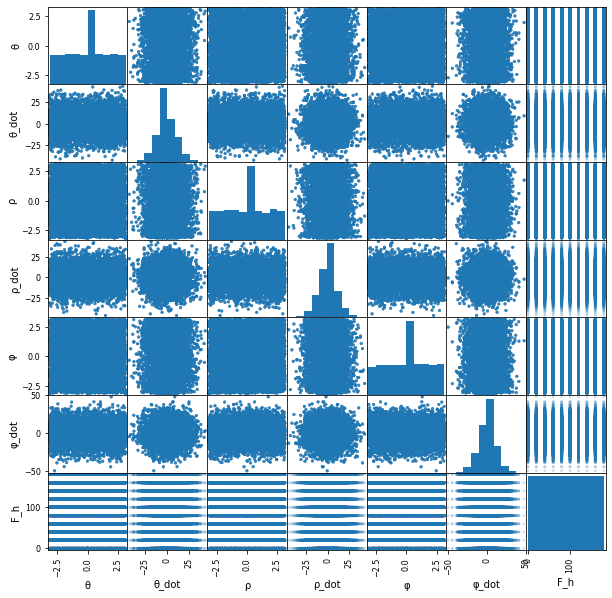

In [48]:
pd.plotting.scatter_matrix(params_a_matrixs_f_load, alpha=0.2, figsize=(10, 10))
plt.show()

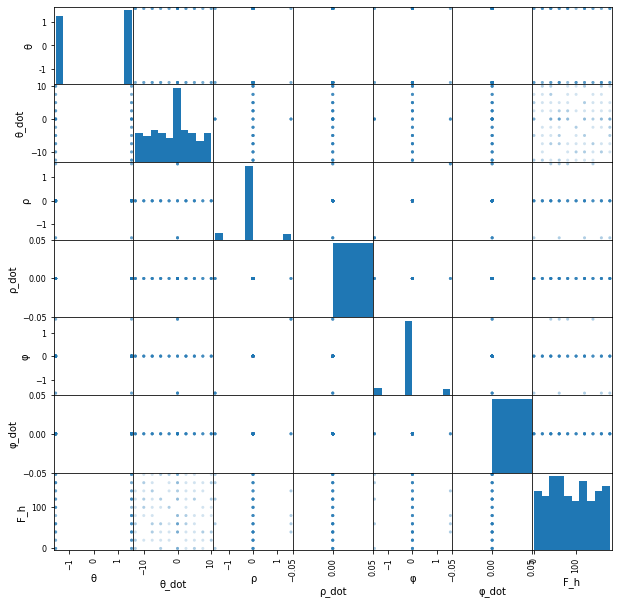

In [46]:
failed_gains = params_a_matrixs_f_load[params_a_matrixs_f_load['K'].isnull()]

pd.plotting.scatter_matrix(failed_gains, alpha=0.2, figsize=(10, 10))
plt.show()

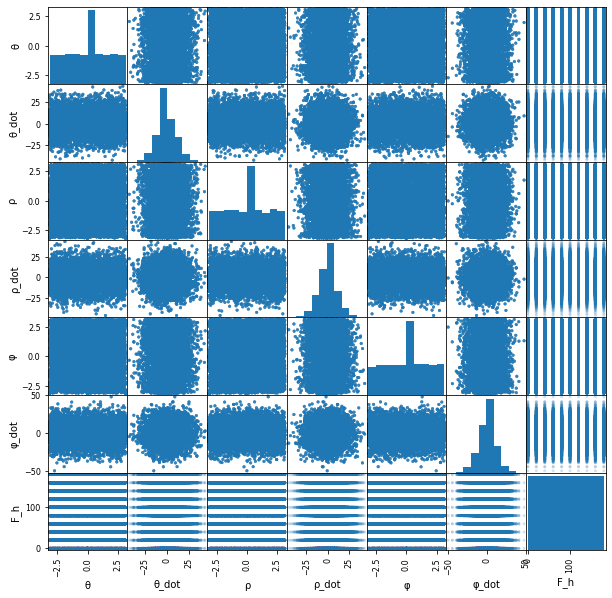

In [47]:
fine_gains = params_a_matrixs_f_load[params_a_matrixs_f_load['K'].notnull()]

pd.plotting.scatter_matrix(fine_gains, alpha=0.2, figsize=(10, 10))
plt.show()

In [60]:
def apply_flat(row):
    return row.flatten()

0        [-370.65205647992116, -31.81946606447866, 30.0...
1        [-79.44143909138234, -6.352896464293281, 77.39...
2        [-125.6531529147469, -27.925017377614267, 163....
3        [-370.65205647992116, -31.81946606447866, 30.0...
4        [146.98547223045125, 13.638903466033838, 312.6...
                               ...                        
90005    [-126.8555825873409, -18.303057215002525, 78.3...
90006    [-13.81132985073485, -0.6149144239797266, 26.5...
90007    [-9.720546210457602, 2.5340555560157707, 253.1...
90008    [-7.61318444853643, -3.33477792143853, 75.2914...
90009    [-25.954176175123898, -0.7260564137583536, 56....
Name: K, Length: 89887, dtype: object

In [82]:
gains_only = fine_gains['K'].apply(apply_flat).apply(pd.Series)
gains_cols = ['K θ', 'K θ_dot', 'K ρ', 'K ρ_dot', 'K φ', 'K φ_dot']
gains_only.columns = gains_cols
fine_gains_flat = pd.concat([fine_gains, gains_only], axis=1)

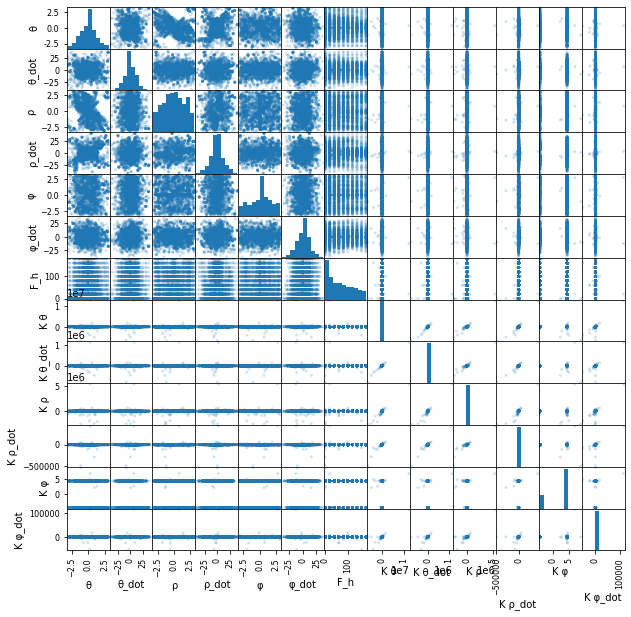

In [162]:
maximum = 2000

initial_selection = (gains_only[gains_cols[0]] > maximum)
for i in gains_cols:
    initial_selection = initial_selection | (gains_only[i] > maximum) | (gains_only[i] < -maximum)

excessive_gains = fine_gains_flat[initial_selection]

pd.plotting.scatter_matrix(excessive_gains, alpha=0.2, figsize=(10, 10))
plt.show()

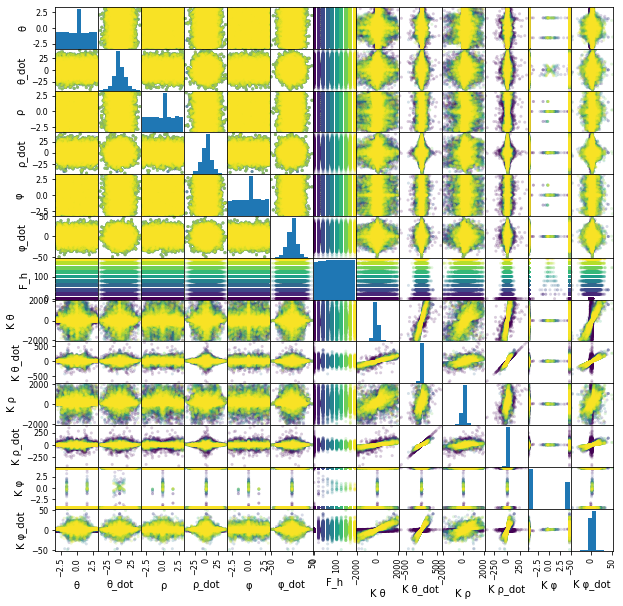

In [163]:
constrained_gains = fine_gains_flat[~initial_selection]

scm = pd.plotting.scatter_matrix(constrained_gains, alpha=0.2, c=constrained_gains['F_h'], figsize=(10, 10))
plt.show()

In [164]:
def set_range(scm_plot):
    for i in range(scm.shape[0]):
        for j in range(scm.shape[1]):
            if (i == j):
                scm_plot[i,j].set_xlim(scm[i,j].get_xlim())
                scm_plot[i,j].set_xticklabels(scm[i,j].get_xticklabels())
                scm_plot[i,j].set_yticklabels(scm[i,j].get_yticklabels())
            else:
                scm_plot[i,j].set_xlim(scm[i,j].get_xlim())
                # scm_plot[i,j].set_ylim(scm[i,j].get_ylim())
                scm_plot[i,j].set_xticklabels(scm[i,j].get_xticklabels())
                # scm_plot[i,j].set_yticklabels(scm[i,j].get_yticklabels())

In [165]:
def scatter_plot_selection(selection):
    scm_plot = pd.plotting.scatter_matrix(constrained_gains[selection], alpha=0.2, c=constrained_gains[selection]['F_h'], figsize=(10, 10))
    set_range(scm_plot)
    plt.show()

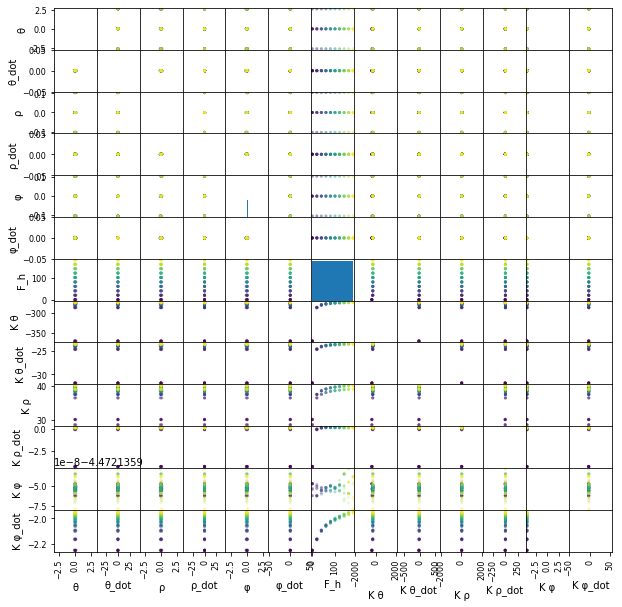

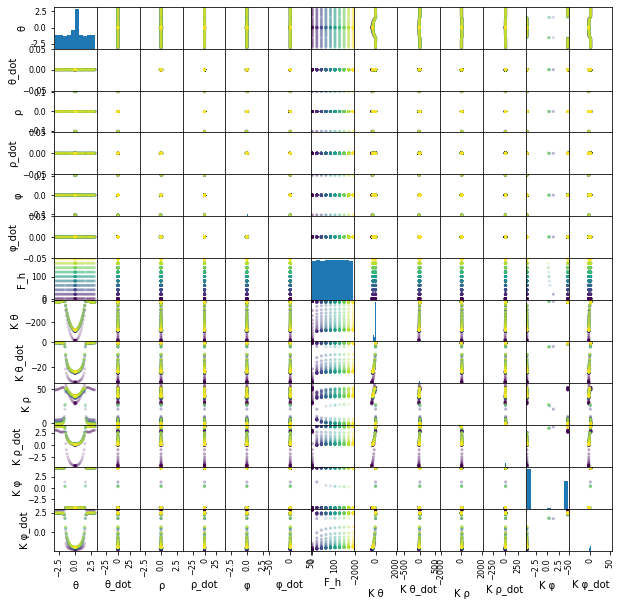

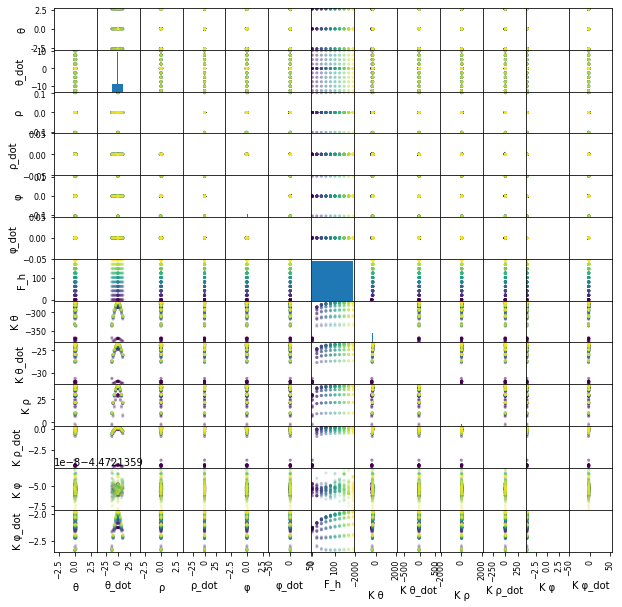

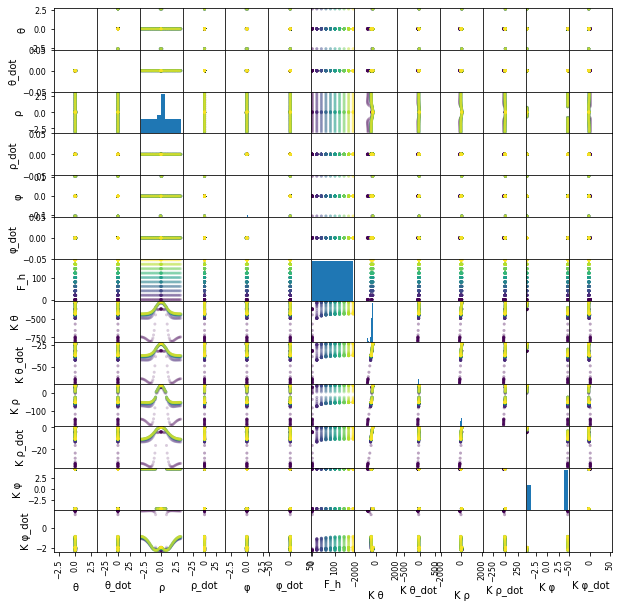

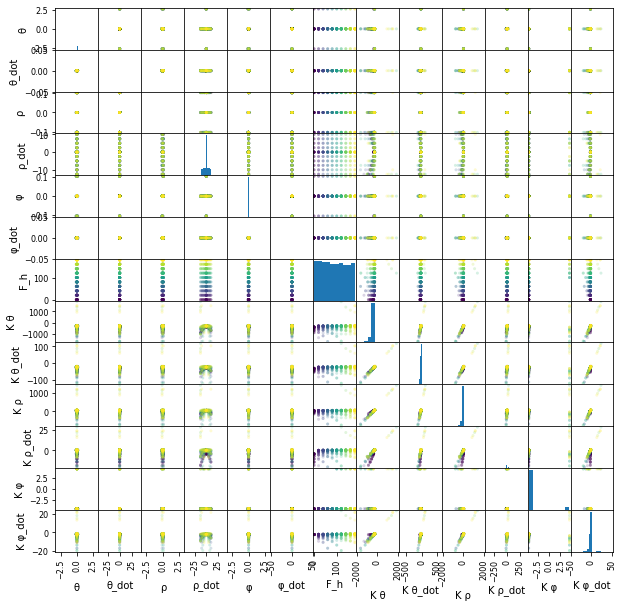

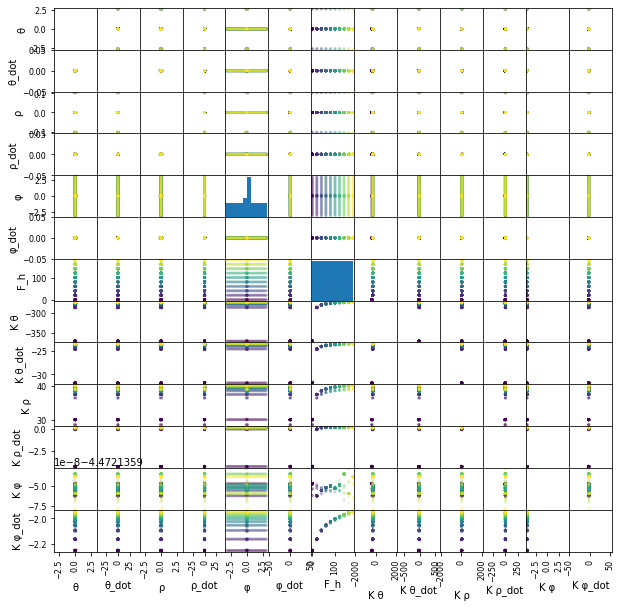

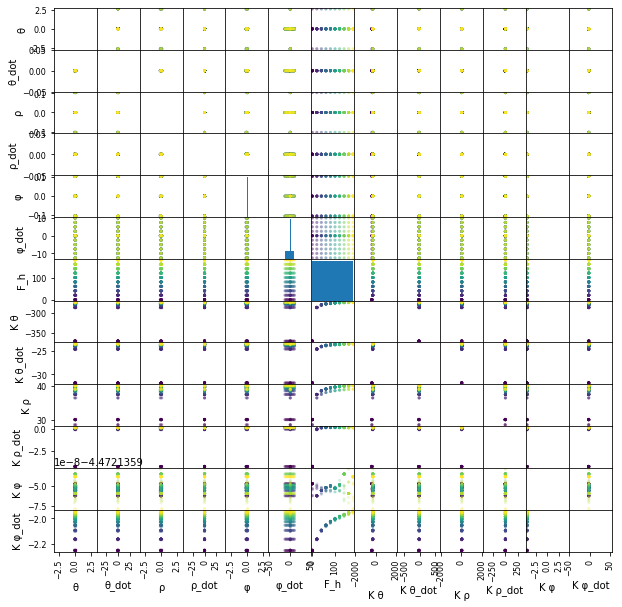

In [166]:
selections = []
for col in angle_cols:
    selections.append((constrained_gains[col] > -0.2) & (constrained_gains[col] < 0.2))

scatter_plot_selection(selections[0] & selections[1] & selections[2] & selections[3] & selections[4] & selections[5])

scatter_plot_selection(selections[1] & selections[2] & selections[3] & selections[4] & selections[5])

scatter_plot_selection(selections[0] & selections[2] & selections[3] & selections[4] & selections[5])

scatter_plot_selection(selections[0] & selections[1] & selections[3] & selections[4] & selections[5])

scatter_plot_selection(selections[0] & selections[1] & selections[2] & selections[4] & selections[5])

scatter_plot_selection(selections[0] & selections[1] & selections[2] & selections[3] & selections[5])

scatter_plot_selection(selections[0] & selections[1] & selections[2] & selections[3] & selections[4])

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


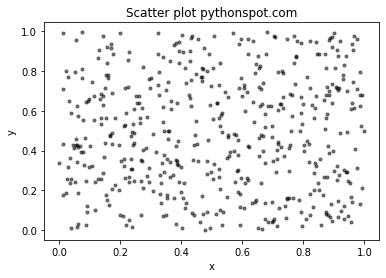

In [38]:
# Create data
N = 500
x = np.random.rand(N)
y = np.random.rand(N)
colors = (0,0,0)
area = np.pi*3

# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title('Theta over K')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

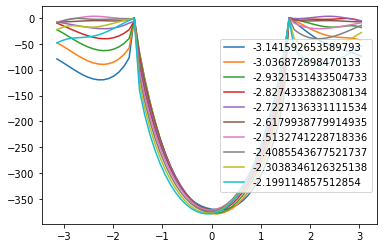

In [43]:
state = 0
gs = []
for j in range(len(K_theta[0])):
    graph = []
    for i in range(len(K_theta)):
        graph.append(K_theta[i][j][0,state])
    gs.append(graph)

for i, graph in enumerate(gs):
    plt.plot(theta_x_scale, graph, label=f"{theta_x_scale[i]}")

plt.legend()
plt.show()

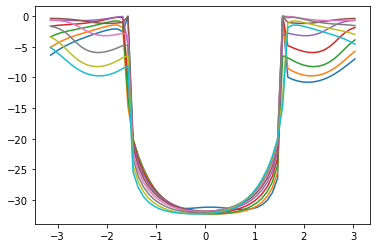

In [135]:
state = 1
gs = []
for j in range(len(K_theta[0])):
    graph = []
    for i in range(len(K_theta)):
        graph.append(K_theta[i][j][0,state])
    gs.append(graph)

for graph in gs:
    plt.plot(theta_x_scale, graph)
    
plt.show()

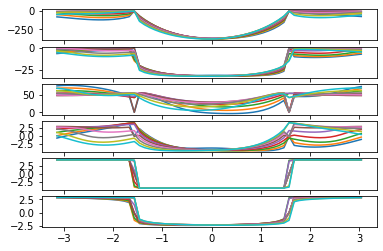

In [45]:
K_360 = K_theta

fig, axs = plt.subplots(6)

for state in range(6):
    gs = []
    for j in range(len(K_360[0])):
        graph = []
        for i in range(len(K_360)):
            graph.append(K_360[i][j][0,state])
        gs.append(graph)

    for graph in gs:
        axs[state].plot(theta_x_scale, graph)
    
plt.show()

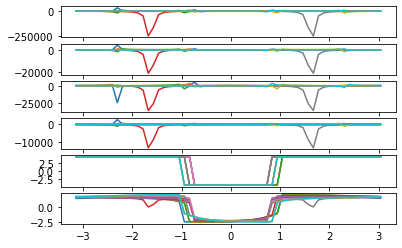

In [46]:
K_360 = K_roh

fig, axs = plt.subplots(6)

for state in range(6):
    gs = []
    for j in range(len(K_360[0])):
        graph = []
        for i in range(len(K_360)):
            graph.append(K_360[i][j][0,state])
        gs.append(graph)

    for graph in gs:
        axs[state].plot(theta_x_scale, graph)

plt.show()

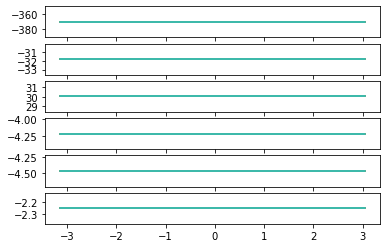

In [136]:
K_360 = K_sigma

fig, axs = plt.subplots(6)

for state in range(6):
    gs = []
    for j in range(len(K_360[0])):
        graph = []
        for i in range(len(K_360)):
            graph.append(K_360[i][j][0,state])
        gs.append(graph)

    for graph in gs:
        axs[state].plot(theta_x_scale, graph)

plt.show()

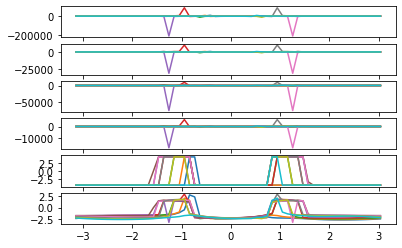

In [137]:
K_360 = K_diag

fig, axs = plt.subplots(6)

for state in range(6):
    gs = []
    for j in range(len(K_360[0])):
        graph = []
        for i in range(len(K_360)):
            graph.append(K_360[i][j][0,state])
        gs.append(graph)

    for graph in gs:
        axs[state].plot(theta_x_scale, graph)

plt.show()

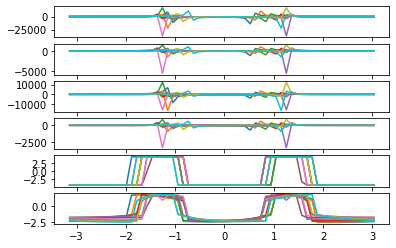

In [152]:
K_360 = K_c_diag

fig, axs = plt.subplots(6)

for state in range(6):
    gs = []
    for j in range(len(K_360[0])):
        graph = []
        for i in range(len(K_360)):
            graph.append(K_360[i][j][0,state])
        gs.append(graph)

    for graph in gs:
        axs[state].plot(theta_x_scale, graph)

plt.show()

## Simulation

### Uncontrolled Pendulum Simulation

#### Initial Values

In [334]:
import math

dt = 0.01
timeline = np.arange(0., 10., dt)

offset = 0.1
θ_up_0 = offset
θ_down_0 = math.pi + offset

x_0_up = np.float64([θ_up_0, 0, 0, 0, 0, 0])
x_0_down = np.float64([θ_down_0, 0, 0, 0, 0, 0])

In [335]:
sympy.Matrix(x_0_up)

Matrix([
[0.1],
[0.0],
[0.0],
[0.0],
[0.0],
[0.0]])

In [336]:
sympy.Matrix(x_0_down)

Matrix([
[3.24159265358979],
[             0.0],
[             0.0],
[             0.0],
[             0.0],
[             0.0]])

#### Simulation via A matrix

In [337]:
import scipy.integrate as integrate

def apply(y, t):
    return A_local @ y

A_local = A_j_up
solution_up_lin = integrate.odeint(apply, x_0_up, timeline)

A_local = A_j_down
solution_down_lin = integrate.odeint(apply, x_0_down, timeline)

#### Simulation via differential equations

In [411]:
f_θ_c = f_θ.subs(specs).subs(free)
f_dθ_c = f_dθ.subs(specs).subs(free)
f_ρ_c = f_ρ.subs(specs).subs(free)
f_dρ_c = f_dρ.subs(specs).subs(free)
f_φ_c = f_φ.subs(specs).subs(free)
f_dφ_c = f_dφ.subs(specs).subs(free)

f_θ_c_b = f_θ.subs(specs).subs(blocked)
f_dθ_c_b = f_dθ.subs(specs).subs(blocked)
f_ρ_c_b = f_ρ.subs(specs).subs(blocked)
f_dρ_c_b = f_dρ.subs(specs).subs(blocked)
f_φ_c_b = f_φ.subs(specs).subs(blocked)
f_dφ_c_b = f_dφ.subs(specs).subs(blocked)

In [412]:
(f_dθ_c_b - f_dθ_c).simplify()

0

In [413]:
(f_dρ_c_b - f_dρ_c).simplify()

(2.10125*Derivative(ρ(t), t) - 0.838203551912568*Derivative(φ(t), t))/(0.0191675*cos(ρ(t)) - 0.027205625)

In [414]:
(f_dφ_c_b - f_dφ_c).simplify()

216.151263261542*Derivative(ρ(t), t) - 86.2242744158062*Derivative(φ(t), t)

In [415]:
precision = 2

ddx = [0,0,0]

def update_ddx(ddx_in):
    ddx = ddx_in

def apply_deq(y, t):
    ret = np.zeros(6)
    ret[0] = y[1]
    ret[2] = y[3]
    ret[4] = y[5]

    if (t < 0):
        for _ in range(precision):
            ret[1] = linearice(f_dθ_c, y, ddx)
            ret[3] = linearice(f_dρ_c, y, ddx)
            ret[5] = linearice(f_dφ_c, y, ddx)
            update_ddx([ret[1], ret[3], ret[5]])
    else:
        for _ in range(precision):
            ret[1] = linearice(f_dθ_c_b, y, ddx)
            ret[3] = linearice(f_dρ_c_b, y, ddx)
            ret[5] = linearice(f_dφ_c_b, y, ddx)
            update_ddx([ret[1], ret[3], ret[5]])
    return ret

In [416]:
update_ddx([0,0,0])
solution_up_deq = integrate.odeint(apply_deq, x_0_up, timeline, mxstep=50)

In [ ]:
update_ddx([0,0,0])
solution_down_deq = integrate.odeint(apply_deq, x_0_down, timeline, mxstep=30)

ValueError: x and y must have same first dimension, but have shapes (2000,) and (1000,)

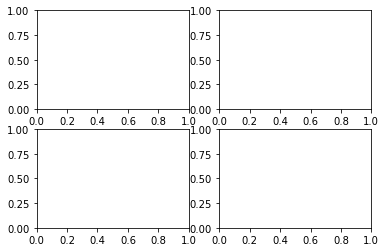

In [417]:
%matplotlib inline

import matplotlib.pyplot as plt

states = state_x
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])


axs[0,0].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Uncontrolled Pendulum")

### Controlled Pendulum Simulation

#### Initial Values

In [418]:
dt = 0.01
timeline = np.arange(0., 20., dt)

offset = 0.1
θ_up_0 = offset
θ_down_0 = math.pi + offset

x_0_up = np.float64([θ_up_0, 0, 0.3, 0, 0, 0])
x_0_down = np.float64([θ_down_0, 0, 0.3, 0, 0, 0])

#### Control of A Matrix

In [419]:
def apply_k(y_k, t):
    w = np.float64([0, 0, 0, 0, 0, 0])
    if (t > 5):
        w = np.float64([0, 0, 0, 0, 2 * math.pi, 0])
    if (t > 18):
        w = np.float64([0, 0, 0, 0, 0, 0])
    return A_local @ y_k - np.array(B) * np.array(K) @ (y_k - w)

A_local = A_j_up
K = K_up

solution_up_lin_k = integrate.odeint(apply_k, x_0_up, timeline)

A_local = A_j_down
K = K_down

solution_down_lin_k = integrate.odeint(apply_k, x_0_down, timeline)

#### Control of diffential equations

In [ ]:
def apply_deq_k(y_k, t):
    retA = apply_deq(y_k, t)
    w = np.float64([0, 0, 0, 0, 0, 0])
    if (t > 5):
        w = np.float64([0, 0, 0, 0, 2 * math.pi, 0])
    if (t > 18):
        w = np.float64([0, 0, 0, 0, 0, 0])
    retK = np.array(B) * np.array(K) @ (y_k - w)
    return retA - retK

K = K_up_blocked
solution_up_deq_k = integrate.odeint(apply_deq_k, x_0_up, timeline)

K = K_down
solution_down_deq_k = integrate.odeint(apply_deq_k, x_0_down, timeline)

In [ ]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Controlled Pendulum")

In [ ]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Controlled Pendulum (free axis range)")

In [ ]:
import tqdm

def getPositions(solution):
    # x_ow, y_ow, x_iw, y_iw, x_m, y_m
    positions = sympy.zeros(6, len(solution))
    control_output = sympy.zeros(1, len(solution))

    for tp in tqdm.tqdm(range(len(solution))):
        results = {
            (θ.diff(t, t), 0),
            (θ.diff(t), solution[tp, 1]),
            (θ, solution[tp, 0]),
            (ρ.diff(t, t), 0),
            (ρ.diff(t), solution[tp, 3]),
            (ρ, solution[tp, 2]),
            (φ.diff(t, t), 0),
            (φ.diff(t), solution[tp, 5]),
            (φ, solution[tp, 4]),
            (y.diff(t, t), 0),
            (y.diff(t), 0),
            (y, 0)
        }
        positions[0, tp] = x_ow.subs(specs).subs(results)
        positions[1, tp] = y_ow.subs(specs).subs(results)
        positions[2, tp] = x_iw.subs(specs).subs(results)
        positions[3, tp] = y_iw.subs(specs).subs(results)
        positions[4, tp] = x_m.subs(specs).subs(results)
        positions[5, tp] = y_m.subs(specs).subs(results)
        w = np.float64([0, 0, 0, 0, 0, 0])
        if ((tp * dt) > 5):
            w = np.float64([0, 0, 0, 0, 1, 0])
        if ((tp * dt) > 18):
            w = np.float64([0, 0, 0, 0, 0, 0])
        control_output[0, tp] = -K.dot(solution[tp, :] - w)
    return positions, control_output

positions_up, control_up = getPositions(solution_up_deq)
positions_down, control_down = getPositions(solution_down_deq)

positions_up_k, control_up_k = getPositions(solution_up_deq_k)
positions_down_k, control_down_k = getPositions(solution_down_deq_k)

In [ ]:
solution = solution_down_deq
positions = positions_down
control_output = control_down

In [ ]:
solution = solution_up_deq
positions = positions_up
control_output = control_up

In [ ]:
solution = solution_down_deq_k
positions = positions_down_k
control_output = control_down_k

In [ ]:
solution = solution_up_deq_k
positions = positions_up_k
control_output = control_up_k

In [ ]:
fig, axs = plt.subplots(3)

for row, state in enumerate(states):
    axs[0].plot(timeline, solution[:, row], label=str(state))

axs[1].plot(timeline, positions[0, :].T, label='x_ow')
# axs[1].plot(timeline, positions[1, :].T, label='y_ow')
axs[1].plot(timeline, positions[2, :].T, label='x_iw')
axs[1].plot(timeline, positions[3, :].T, label='y_iw')
axs[1].plot(timeline, positions[4, :].T, label='x_m')
axs[1].plot(timeline, positions[5, :].T, label='y_m')

axs[2].plot(timeline, control_output[0, :].T, label='u')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_ylabel('rad or rad/s')
axs[1].set_ylabel('m')
axs[2].set_ylabel('Nm')

axs[2].set_xlabel('t')

plt.show()

### Robot Animation

In [429]:
import time

import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool, Range
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [430]:
x_dots = np.float64([0,0,0])
y_dots = np.float64([0,0,0])

c_ow = float(r_3.subs(specs))
c_iw = float(r_1.subs(specs))
c_m = float(r_1.subs(specs))

radii = [c_ow, c_iw, c_m]
colors = ["#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x_dots, 30+2*y_dots)]

radii

[0.1025, 0.0365, 0.0365]

In [431]:
TOOLS="crosshair,pan,wheel_zoom,box_zoom,reset,tap,box_select,lasso_select"

p = figure(tools=TOOLS, x_range = [-0.1,0.4], y_range = [-0.1,0.4])
p.axis.major_label_text_font_size = "24px"
hover = HoverTool(tooltips=None, mode="vline")
p.add_tools(hover)
r = p.circle(x_dots, y_dots, radius=radii, 
             fill_color=colors, fill_alpha=0.6, line_color=None,
             hover_fill_color="black", hover_fill_alpha=0.7, hover_line_color=None)

In [432]:
# get and explicit handle to update the next show cell with
target = show(p, notebook_handle=True)

In [433]:
i = 0
for tp in range(len(timeline)):
    i +=1 
    p.title.text = str(i)

    r.data_source.data['x'] = np.array([float(positions[0, tp]), float(positions[2, tp]), float(positions[4, tp]) ])
    r.data_source.data['y'] = np.array([float(positions[1, tp]), float(positions[3, tp]), float(positions[5, tp]) ])

    # push updates to the plot continuously using the handle (intererrupt the notebook kernel to stop)
    push_notebook(handle=target)
    time.sleep(dt * 2)

In [244]:
K_roh
K_theta
K_sigma
K_diag

A_j_roh
A_j_theta
A_j_sigma
A_j_diag

theta_x_scale
theta_dot_x_scale

total_length = len(theta_x_scale) * len(theta_dot_x_scale) * 4

# Input the linearization point
X_training = np.zeros((total_length, len(state_x)))

# Output the controller gains
Y_training_K = np.zeros((total_length, len(state_x)))
Y_training_A = np.zeros((total_length, len(state_x) * len(state_x)))

pos = 0

for i, value in enumerate(theta_x_scale):
    for j, value_dot in enumerate(theta_dot_x_scale):
        X_training[pos, 0] = value
        X_training[pos, 1] = value_dot
        for state in range(len(state_x)):    
            Y_training_K[pos, state] = K_theta[i][j][0,state]
        state = 0
        for k in range(len(state_x)):
            for l in range(len(state_x)):
                Y_training_A[pos, state] = A_j_theta[i][j][k,l]
                state += 1
        pos += 1

for i, value in enumerate(theta_x_scale):
    for j, value_dot in enumerate(theta_dot_x_scale):
        X_training[pos, 2] = value
        X_training[pos, 3] = value_dot
        for state in range(len(state_x)):    
            Y_training_K[pos, state] = K_roh[i][j][0,state]
        state = 0
        for k in range(len(state_x)):
            for l in range(len(state_x)):
                Y_training_A[pos, state] = A_j_roh[i][j][k,l]
                state += 1
        pos += 1
    
for i, value in enumerate(theta_x_scale):
    for j, value_dot in enumerate(theta_dot_x_scale):
        X_training[pos, 4] = value
        X_training[pos, 5] = value_dot
        for state in range(len(state_x)):    
            Y_training_K[pos, state] = K_sigma[i][j][0,state]
        state = 0
        for k in range(len(state_x)):
            for l in range(len(state_x)):
                Y_training_A[pos, state] = A_j_sigma[i][j][k,l]
                state += 1
        pos += 1
        
for i, value in enumerate(theta_x_scale):
    for j, value_dot in enumerate(theta_dot_x_scale):
        X_training[pos, 0] = value
        X_training[pos, 1] = value_dot
        X_training[pos, 2] = value
        X_training[pos, 3] = value_dot
        X_training[pos, 4] = value
        X_training[pos, 5] = value_dot
        for state in range(len(state_x)):    
            Y_training_K[pos, state] = K_diag[i][j][0,state]
        state = 0
        for k in range(len(state_x)):
            for l in range(len(state_x)):
                Y_training_A[pos, state] = A_j_diag[i][j][k,l]
                state += 1
        pos += 1

print(f"{pos} of {total_length}")


total_length_test = len(theta_x_scale) * len(theta_dot_x_scale) * 1

# Input the linearization point
X_test = np.zeros((total_length_test, len(state_x)))

# Output the controller gains
Y_test_K = np.zeros((total_length_test, len(state_x)))
Y_test_A = np.zeros((total_length_test, len(state_x) * len(state_x)))

# Reset pos for test data arrays
pos = 0
for i, value in enumerate(theta_x_scale):
    for j, value_dot in enumerate(theta_dot_x_scale):
        X_test[pos, 0] = value * -1
        X_test[pos, 1] = value_dot * -1
        X_test[pos, 2] = value
        X_test[pos, 3] = value_dot
        X_test[pos, 4] = value
        X_test[pos, 5] = value_dot * -1
        for state in range(len(state_x)):    
            Y_test_K[pos, state] = K_c_diag[i][j][0,state]
        state = 0
        for k in range(len(state_x)):
            for l in range(len(state_x)):
                Y_test_A[pos, state] = A_j_c_diag[i][j][k,l]
                state += 1
        pos += 1

print(f"{pos} of {total_length_test}")

2400 of 2400
600 of 600


In [245]:
remove_rows = []

for pos in range(total_length):
    for state in range(len(state_x)):
        if(Y_training[pos,state] == 0 or Y_training[pos,state] > 5000 or Y_training[pos,state] < -5000):
            remove_rows.append(pos)
            break

Clean_X = np.delete(X_training, remove_rows, 0)
Clean_Y_K = np.delete(Y_training_K, remove_rows, 0)
Clean_Y_A = np.delete(Y_training_A, remove_rows, 0)

print(f"Remove {len(remove_rows)} rows: {X_training.shape} -> {Clean_X.shape}")

Remove 57 rows: (2400, 6) -> (2343, 6)


In [246]:
remove_rows = []

for pos in range(total_length_test):
    for state in range(len(state_x)):
        if(Y_test_K[pos,state] == 0 or Y_test_K[pos,state] > 5000 or Y_test_K[pos,state] < -5000):
            remove_rows.append(pos)
            break

Clean_X_test = np.delete(X_test, remove_rows, 0)
Clean_Y_test_K = np.delete(Y_test_K, remove_rows, 0)
Clean_Y_test_A = np.delete(Y_test_A, remove_rows, 0)

print(f"Remove {len(remove_rows)} rows: {X_test.shape} -> {Clean_X_test.shape}")

Remove 21 rows: (600, 6) -> (579, 6)


In [247]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

knn = KNeighborsRegressor()
knn_regr_k = MultiOutputRegressor(knn)
knn_regr_k.fit(Clean_X,Clean_Y_K)

lr = LinearRegression()
lr_regr_k = MultiOutputRegressor(lr)
lr_regr_k.fit(Clean_X,Clean_Y_K)

knn = KNeighborsRegressor()
knn_regr_a = MultiOutputRegressor(knn)
knn_regr_a.fit(Clean_X,Clean_Y_A)

lr = LinearRegression()
lr_regr_a = MultiOutputRegressor(lr)
lr_regr_a.fit(Clean_X,Clean_Y_A)

MultiOutputRegressor(estimator=LinearRegression())

In [248]:
knn_predict_k = knn_regr_k.predict([[0,0,0,0,0,0]])
lr_predict_k = lr_regr_k.predict([[0,0,0,0,0,0]])

K_target = np.array(K_up)

knn_errors = (knn_predict_k**2 - K_target**2) / K_target**2
lr_errors = (lr_predict_k**2 - K_target**2) / K_target**2

print("knn")
print(knn_errors.sum() / 6)
print(knn_errors)

print("lr")
print(lr_errors.sum() / 6)
print(lr_errors)

knn
-0.0001357291470175793
[[-1.28213734e-03 -2.58318651e-04  1.83265811e-03 -8.53990630e-04
   4.02543953e-10 -2.52586776e-04]]
lr
-0.6253789856214221
[[-0.4000874  -0.38343099 -0.91472303 -0.26829145 -0.88969187 -0.89604918]]


In [263]:
knn_predict_k = knn_regr_k.predict(Clean_X)
lr_predict_k = lr_regr_k.predict(Clean_X)

K_target = np.array(Clean_Y_K)

knn_errors = (knn_predict_k - K_target)**2
lr_errors = (lr_predict_k - K_target)**2

print("knn")
print(knn_errors.sum() / (6 * len(K_target)))
print(knn_errors)

print("lr")
print(lr_errors.sum() / (6 * len(K_target)))
print(lr_errors)

knn
22750.148520686445
[[1.52305597e+02 1.08973072e+00 1.05802824e+00 5.35130472e-01
  3.78483800e-22 1.53703916e-03]
 [1.42549100e+02 8.44917191e-01 1.87584770e-01 4.27840346e-01
  7.08839309e-20 1.48270404e-03]
 [1.33355871e+02 3.43464320e-01 7.70667172e-03 1.99830062e-01
  8.99524100e-21 1.36472504e-03]
 ...
 [4.23138087e+01 7.52965526e-01 3.64279223e+01 5.29319779e-01
  1.25207752e-18 7.03311201e-03]
 [5.77040911e+00 1.41394258e+00 2.01338942e+02 1.01772461e+00
  1.06162893e-19 1.44968199e-02]
 [1.66409619e+01 5.07415483e-01 1.77835033e+03 6.51690539e-01
  2.83102565e-20 2.55054353e-02]]
lr
72087.02214528949
[[2.11388272e+04 1.61476903e+02 1.83383155e+03 5.22127286e-03
  3.04951217e+01 1.08311020e+01]
 [3.21980961e+04 1.98690923e+02 1.22852806e+03 5.39880798e-01
  3.15160461e+01 1.13280740e+01]
 [4.30922468e+04 2.54986369e+02 7.36302041e+02 2.87413177e+00
  3.25537796e+01 1.18360429e+01]
 ...
 [7.76862361e+04 5.67266520e+02 1.04497908e+04 2.96961581e+02
  8.48405149e+00 1.33744415e

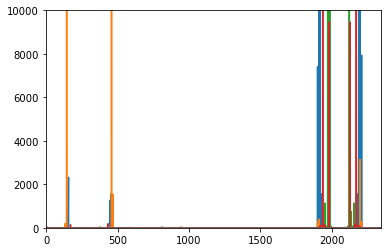

In [250]:
plt.plot(knn_errors)
plt.axis([0, len(K_target), 0, 10000])
plt.show()

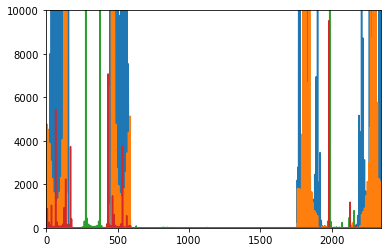

In [251]:
plt.plot(lr_errors)
plt.axis([0, len(K_target), 0, 10000])
plt.show()

In [264]:
knn_predict_k = knn_regr_k.predict(Clean_X_test)
lr_predict_k = lr_regr_k.predict(Clean_X_test)

K_target = np.array(Clean_Y_test_K)

knn_errors = (knn_predict_k - K_target)**2
lr_errors = (lr_predict_k - K_target)**2

print("knn")
print(knn_errors.sum() / (6 * len(K_target)))
print(knn_errors)

print("lr")
print(lr_errors.sum() / (6 * len(K_target)))
print(lr_errors)

knn
115372.04733976418
[[3.11261956e+02 3.93734892e-01 2.84289989e+02 3.41576794e-01
  6.65175475e-18 6.97176440e-03]
 [2.13685787e+02 2.81815372e-01 1.59731524e+02 2.88668697e-01
  5.87486470e-19 7.93997404e-03]
 [1.37327733e+02 1.56133744e-01 8.29790676e+01 2.06587713e-01
  2.94052332e-18 8.04938247e-03]
 ...
 [7.55553509e+01 3.43371769e-02 3.87222900e+01 9.32129550e-02
  3.38217871e-19 6.61565064e-03]
 [1.51443619e+02 7.20301132e-02 9.15070818e+01 1.53138229e-01
  3.79280445e-18 9.21175303e-03]
 [2.53822535e+02 1.31025116e-01 1.79180571e+02 2.05328506e-01
  4.84054793e-18 9.49408997e-03]]
lr
207882.65159840835
[[1.01958201e+05 7.31498672e+02 5.77009703e+04 4.12377582e+02
  9.45703159e+00 2.57445934e+00]
 [6.56441796e+04 5.79051250e+02 2.35677340e+04 3.31307533e+02
  8.95789677e+00 2.23054021e+00]
 [4.85221168e+04 4.65469777e+02 7.70957418e+03 2.66029114e+02
  8.47229343e+00 1.80527818e+00]
 ...
 [7.91852045e+04 6.36139748e+02 8.44970100e+03 3.31414278e+02
  8.16480539e+00 1.44626636

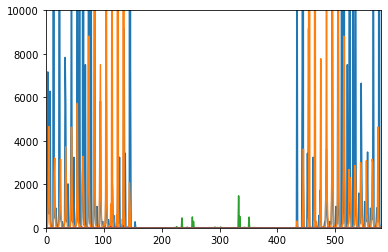

In [253]:
plt.plot(knn_errors)
plt.axis([0, len(K_target), 0, 10000])
plt.show()

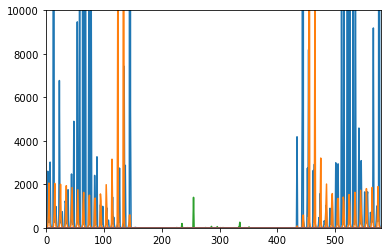

In [254]:
plt.plot(lr_errors)
plt.axis([0, len(K_target), 0, 10000])
plt.show()

In [265]:
knn_predict_a = knn_regr_a.predict(Clean_X_test)
lr_predict_a = lr_regr_a.predict(Clean_X_test)

A_target = np.array(Clean_Y_test_A)

knn_errors = (knn_predict_a - A_target)**2
lr_errors = (lr_predict_a - A_target)**2

print("knn")
print(knn_errors.sum() / (6 * 6 * len(A_target)))
print(knn_errors)

print("lr")
print(lr_errors.sum() / (6 * 6 * len(A_target)))
print(lr_errors)

knn
1.0116897913914649
[[ 0.          0.          0.         ... 25.96095837  0.
   0.        ]
 [ 0.          0.          0.         ... 16.61501336  0.
   0.        ]
 [ 0.          0.          0.         ...  9.34594501  0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  3.97282435  0.
   0.        ]
 [ 0.          0.          0.         ...  8.93885479  0.
   0.        ]
 [ 0.          0.          0.         ... 15.8912974   0.
   0.        ]]
lr
580.3018928098027
[[ 0.          0.          0.         ...  4.18692652  0.
   0.        ]
 [ 0.          0.          0.         ...  4.25975275  0.
   0.        ]
 [ 0.          0.          0.         ...  4.33320689  0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 11.73796699  0.
   0.        ]
 [ 0.          0.          0.         ... 15.41615501  0.
   0.        ]
 [ 0.          0.          0.         ... 19.5948822   0.
   0.        ]]


In [256]:
import pickle

pkl_filename = "k_knn.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(knn_regr, file)

pkl_filename = "k_lr.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_regr, file)

pkl_filename = "A_knn.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(knn_regr, file)

pkl_filename = "A_lr.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_regr, file)

In [257]:
Combined_X = np.concatenate((Clean_X, Clean_X_test))
Combined_Y = np.concatenate((Clean_Y_K, Clean_Y_test_K))

knn = KNeighborsRegressor()
knn_regr_k = MultiOutputRegressor(knn)
knn_regr_k.fit(Combined_X,Combined_Y)

lr = LinearRegression()
lr_regr_k = MultiOutputRegressor(lr)
lr_regr_k.fit(Combined_X,Combined_Y)

MultiOutputRegressor(estimator=LinearRegression())

In [258]:
Combined_X = np.concatenate((Clean_X, Clean_X_test))
Combined_Y = np.concatenate((Clean_Y_A, Clean_Y_test_A))

knn = KNeighborsRegressor()
knn_regr_a = MultiOutputRegressor(knn)
knn_regr_a.fit(Combined_X,Combined_Y)

lr = LinearRegression()
lr_regr_a = MultiOutputRegressor(lr)
lr_regr_a.fit(Combined_X,Combined_Y)

MultiOutputRegressor(estimator=LinearRegression())

In [259]:
pkl_filename = "bb_k_knn.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(knn_regr, file)

pkl_filename = "bb_k_lr.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_regr, file)

pkl_filename = "bb_A_knn.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(knn_regr, file)

pkl_filename = "bb_A_lr.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_regr, file)